## Settings and import

In [1]:
aeTypes = ["Simple", "CAE", "VAE", "AAE"]

In [2]:
import torch
import pickle
import numpy as np
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import datetime

from AaeEncoder import AaeEncoder

## NET class

In [30]:
class AENet(nn.Module):
    def __init__(self, aeType, X_dim=28, N=32, 
                 z_dim=6, dropout=0.1):
        # Check of input parameters correctness
        if aeType not in aeTypes:
            raise ValueError("aeType not in aeTypes")
        #
        super(AENet, self).__init__()
        #
        # matching
        self.aeType = aeType
        self.X_dim = X_dim
        self.N = N
        self.z_dim = z_dim
        self.dropout = dropout
        #
        # torch net
        self.fc1  = nn.Linear(X_dim, N)
        self.fc2  = nn.Linear(N, z_dim)
        self.fc3  = nn.Linear(z_dim, N)
        self.fc4  = nn.Linear(N, X_dim)
        self.fc22 = nn.Linear(N, z_dim) # for VAE encoder
        # 
        # encode function choosing
        if aeType == "VAE":
            self.encode = self.encodeVAE
        #
        # forward function choosing
        if aeType == "VAE":
            self.forward = self.forwardVAE
        #
        # loss function choosing
        if aeType == "CAE":
            self.lossFunction = self.lossFunctionCAE
        if aeType == "VAE":
            self.lossFunction = self.lossFunctionVAE
        #
        
    # encode functions
    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return F.relu(self.fc2(h1))

    def encodeVAE(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc2(h1), self.fc22(h1)

    # decode functions
    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    # forward functions
    def forward(self, x):
        hid = self.encode(x)
        rec = self.decode(hid)
        return hid, rec

    # VAE only
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)

    def forwardVAE(self, x):
        mu, logvar = self.encode(x)  # .view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar
    
    # loss functions
    def lossFunction(self, x, recon_x):
        # h, W, lam are ambigous
        mse = torch.nn.functional.mse_loss(recon_x, x)
        #mse = torch.nn.MSELoss(recon_x, x, size_average=False)
        #print(recon_x, x, mse)
        return mse

    # Reconstruction + KL divergence losses summed over all elements and batch
    def lossFunctionCAE(self, x, recon_x, h, W, lam):
        """Compute the Contractive AutoEncoder Loss
        Evalutes the CAE loss, which is composed as the summation of a Mean
        Squared Error and the weighted l2-norm of the Jacobian of the hidden
        units with respect to the inputs.
        See reference below for an in-depth discussion:
          #1: http://wiseodd.github.io/techblog/2016/12/05/contractive-autoencoder
        Args:
            `W` (FloatTensor): (N_hidden x N), where N_hidden and N are the
              dimensions of the hidden units and input respectively.
            `x` (Variable): the input to the network, with dims (N_batch x N)
            recons_x (Variable): the reconstruction of the input, with dims
              N_batch x N.
            `h` (Variable): the hidden units of the network, with dims
              batch_size x N_hidden
            `lam` (float): the weight given to the jacobian regulariser term
        Returns:
            Variable: the (scalar) CAE loss
        """
        mse = torch.nn.functional.mse_loss(recon_x, x)
        #mse = torch.nn.MSELoss(recon_x, x, size_average=False)
        # Since: W is shape of N_hidden x N. So, we do not need to transpose it as
        # opposed to #1
        dh = h * (1 - h) # Hadamard product produces size N_batch x N_hidden
        # Sum through the input dimension to improve efficiency, as suggested in #1
        #print(W, W.shape)
        w_sum = torch.sum(Variable(W)**2, dim=1)
        # unsqueeze to avoid issues with torch.mv
        #w_sum = w_sum.unsqueeze(1) # shape N_hidden x 1
        #print(w_sum, w_sum.shape)
        #print(dh**2)
        w_sum = w_sum.unsqueeze(1)
        #print(w_sum, w_sum.shape)
        contractive_loss = torch.sum(torch.mm(dh**2, w_sum), 0)
        return mse + contractive_loss.mul_(lam)

    # Reconstruction + KL divergence losses summed over all elements and batch
    def lossFunctionVAE(self, recon_x, x, mu, logvar):
        # BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
        BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
        # see Appendix B from VAE paper:
        # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
        # https://arxiv.org/abs/1312.6114
        # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        return BCE + KLD



## Base autoencoder's class

In [31]:
class BaseAutoEncoder(object):
    def __init__(self, X_dim=28, N=32, z_dim=2, 
                       train_batch_size=32, epochs=500, 
                       dropout=0.1, opt_s='Adam', seed=None,
                       aeType='Simple'):
        #
        self.seed = datetime.datetime.now().microsecond if (seed is None) else seed
        self.X_dim = X_dim
        self.N = N
        self.z_dim = z_dim

        self.train_batch_size = train_batch_size
        self.epochs = epochs
        self.dropout = dropout

        self.opts = {'Adam': optim.Adam, 'SGD': optim.SGD}
        self.opt_s = opt_s
        self.opt = self.opts.get(opt_s, optim.Adam)
        if self.opt == optim.Adam:
            self.opt_s = 'Adam'

        self.aeType = aeType
        self.string_params = "%s;seed_%d;z_%d;N_%d;batch_%d;opt_%s;dropout=%f" % (
            aeType, self.seed, self.z_dim, self.N, self.train_batch_size, self.opt_s, self.dropout)

        self.cuda = torch.cuda.is_available()
        
        self.model = None

    def _save_model(self, model, filename):
        torch.save(model, filename)

    def _load_model(self, filename):
        return torch.load(filename)

    def _report_loss(self, epoch, loss):
        print('Epoch-{}; loss: {:.4}'.format(epoch, float(loss)))

    def _train(self, opt, epoch, data):
        '''
        Train procedure for one epoch.
        '''
        return 0

    
    def generate_model(self, data):
        torch.manual_seed(self.seed)

        if self.cuda:
            self.model = AENet(self.aeType, X_dim=self.X_dim, N=self.N, z_dim=self.z_dim,
                               dropout=self.dropout).cuda()
        else:
            self.model = AENet(self.aeType, X_dim=self.X_dim, N=self.N, z_dim=self.z_dim, 
                               dropout=self.dropout)
        # Set learning rates
        gen_lr = 0.0001

        # Set optimizators
        if self.opt == optim.SGD:
            opt_v = self.opt(self.model.parameters(), lr=gen_lr)
        else:
            opt_v = self.opt(self.model.parameters())

        losses = []
        for epoch in range(self.epochs):
            loss = self._train(opt_v, epoch, data)
            if epoch % 10 == 0:
                self._report_loss(epoch, loss)
                losses.append([epoch, loss])

        self._save_model(self.model, self.aeType + '__' + self.string_params + '.pickle')
        return self.model, losses

    def load_model(self, string):
        self.model = self._load_model(self.aeType + '__' + string + '.pickle')

    def get_z(self, data):
        return self.model.encode(data)

## Other autoencoder's class

In [32]:
class OtherAutoEncoder(BaseAutoEncoder):
    def __init__(self, X_dim=28, N=32, z_dim=2, 
                       train_batch_size=32, epochs=500, 
                       dropout=0.1, opt_s='Adam', seed=None,
                       aeType='Simple', additionalParams={}):
        super(OtherAutoEncoder, self).__init__(X_dim, N, z_dim, train_batch_size, 
                                               epochs, dropout, opt_s, seed, aeType)
        
        #
        self.additionalParams = additionalParams

    def _train(self, opt, epoch, data):
        '''
        Train procedure for one epoch.
        '''
        TINY = 1e-15
        # Set the network in train mode (apply dropout when needed)
        self.model.train()
        train_loss = 0

        for X in data:
            X = X.float()
            X = Variable(X)
            if self.cuda:
                X = X.cuda()

            # Init gradients
            opt.zero_grad()

            #recon_batch, mu, logvar = self.model(X)  # ret of forward
            
            # ret of forward and loss
            if self.aeType == "Simple":
                hidden_representation, recon_x = self.model(X)
                loss = self.model.lossFunction(X, recon_x)
            if self.aeType == "CAE":
                hidden_representation, recon_x = self.model(X)
                W1 = self.model.state_dict()['fc1.weight']
                W2 = self.model.state_dict()['fc2.weight']
                W = torch.mm(W2, W1)
                lam = 0.001
                loss = self.model.lossFunction(X, recon_x, hidden_representation, W, lam)
            if self.aeType == "VAE":
                recon_batch, mu, logvar = self.model(X)
                loss = self.model.lossFunction(recon_batch, X, mu, logvar)
            #
            loss.backward()
            train_loss += loss.item()
            opt.step()

        return train_loss


## Interface class

In [33]:
class AutoEncoder(object):
    def __init__(self, X_dim=28, N=32, z_dim=2, 
                       train_batch_size=32, epochs=500, 
                       dropout=0.1, opt_s='Adam', seed=None,
                       aeType='Simple', additionalParams={}):
        #
        # Check of input parameters correctness
        if aeType not in aeTypes:
            raise ValueError("aeType not in aeTypes")
        #
        if aeType == "AAE":
            if 'real_gauss_A' in additionalParams.keys():
                real_gauss_A = additionalParams["real_gauss_A"]
            else:
                raise ValueError("In additionalParams need param real_gauss_A for AAE")
            self.encoder = AaeEncoder(X_dim, N, z_dim, train_batch_size, epochs, 
                                      dropout, opt_s, seed, real_gauss_A)
        else:
            self.encoder = OtherAutoEncoder(X_dim, N, z_dim, train_batch_size, epochs, 
                                      dropout, opt_s, seed, aeType, additionalParams)
            
    def _save_model(self, model, filename):
        self.encoder._save_model(model, filename)

    def _load_model(self, filename):
        return self.encoder._load_model(filename)

    def generate_model(self, data):
        return self.encoder.generate_model(data)

    def load_model(self, string):
        self.encoder.load_model(string)

    def get_z(self, data):
        return self.encoder.get_z(data)


## Test

### Load data

In [34]:
import sys

from loadData import loadData
#from utilityFunctions import LerningCurve, GetFoldsNestedTSCV, \
#                             GetFoldsSlidingWindowTSCW, print_confusion_matrix, \
#                             BinDataBalance, NestedTSCV, \
#                             SlidingWindowTSCW

game = "Game_50-58"
accID = 716773451815976

train_batch_size = 32

In [35]:
import pandas as pd

(X, y) = loadData(PATH_TO_TRAIN_DATA="/home/sdeev/Data_science/Work/AutoManager/Data/TrainFeatures", 
                  game=game, accID=accID)
X = X[[f for f in X.columns if f not in ["Date"]]]#["Date", "cohorts"]]]

             AccID        Date              adset  cohorts  target  \
0  716773451815976  2018-01-02  23842706167870613        1       0   
1  716773451815976  2018-01-03  23842706167870613        2       1   
2  716773451815976  2018-01-02  23842706153450613        1       0   

                     Opt Location  Spend   Reach  Impressions     ...       \
0  OFFSITE_CONVERSIONS_1       US  47.54  3298.0       3969.0     ...        
1  OFFSITE_CONVERSIONS_1       US  61.40  4200.0       4988.0     ...        
2  OFFSITE_CONVERSIONS_7       US  47.11  3480.0       3788.0     ...        

   PurchasesWin3  RevenueWin3  SpendWin7  ReachWin7  ImpressionsWin7  \
0            0.0          0.0      47.54     3298.0           3969.0   
1            0.0          0.0     108.94     7498.0           8957.0   
2            0.0          0.0      47.11     3480.0           3788.0   

   ClicksWin7  InstallsWin7  PayersWin7  PurchasesWin7  RevenueWin7  
0        20.0           0.0         0.0        

/home/sdeev/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


### Preparing data

In [36]:
import torch
import pickle
import numpy as np
import pandas as pd
import math

X = X[[f for f in X.columns if f not in ["Date"]]]
targFeature = "target"
df = X
columns = df.columns
print(len(df.columns))

# fill load list
feat_keys = [c for c in df.columns if c != targFeature]

for f in df.columns:
    if type(df.iloc[0][f]) == str or type(df.iloc[0][f]) == object:
        df[f] = df[f].fillna("")
        df[f] = np.where(pd.isnull(df[f].values), "", df[f].values)
    else:
        df[f] = df[f].fillna(0)
        df[f] = np.where(pd.isnull(df[f].values), 0, df[f].values)
        
#df = df[feat_keys + [targFeature]]

load_list = []
# normalize list by maxs
i = 0
for i in range(len(df[feat_keys])):
    lst_ = np.array(df[feat_keys].iloc[i])
    lst_ = lst_
    load_list.append(lst_.tolist())

# fill array with train_batch_size
if train_batch_size>0:
    data = np.zeros(shape=(int(len(load_list) / train_batch_size), train_batch_size, len(feat_keys)), dtype=float)
    dt = np.zeros(shape=(train_batch_size, len(feat_keys)), dtype=float)
    upindex = 0
    index = 0
    for lst in load_list:
        dt[index, :] = lst
        index = index + 1
        if index == train_batch_size:
            index = 0
            #print(dt)
            data[upindex, :, :] = dt
            # if upindex==0:
            #    print(dt)
            dt = np.zeros(shape=(train_batch_size, len(feat_keys)), dtype=float)
            upindex = upindex + 1

    data = torch.from_numpy(data)  # learn_list)
    # X = Variable(torch.from_numpy(learn_list).float(), requires_grad = True)
else:
    data = torch.from_numpy(np.array([load_list]))
    data = data[0]
    #data = torch.from_numpy(data)


54


### Run Simple encoder

In [43]:
simple = AutoEncoder(X_dim=data.shape[2], N=8, z_dim=2, 
                     train_batch_size=32, epochs=500, 
                     dropout=0.4, opt_s='Adam', seed=None,
                     aeType='Simple')
(model, losses) = simple.generate_model(data)

h = simple.get_z(torch.from_numpy(df[feat_keys].values).float())
h = model.encode(torch.from_numpy(df[feat_keys].values).float())

hid = h.detach().numpy()
np.sum(hid, axis=0)

Epoch-0; loss: 29.26
Epoch-10; loss: 4.383
Epoch-20; loss: 3.873
Epoch-30; loss: 3.735
Epoch-40; loss: 3.702
Epoch-50; loss: 3.677
Epoch-60; loss: 3.66
Epoch-70; loss: 3.646
Epoch-80; loss: 3.63
Epoch-90; loss: 3.615
Epoch-100; loss: 3.598
Epoch-110; loss: 3.575
Epoch-120; loss: 3.544
Epoch-130; loss: 3.494
Epoch-140; loss: 3.439
Epoch-150; loss: 3.39
Epoch-160; loss: 3.331
Epoch-170; loss: 3.219
Epoch-180; loss: 3.119
Epoch-190; loss: 3.047
Epoch-200; loss: 3.0
Epoch-210; loss: 2.97
Epoch-220; loss: 2.95
Epoch-230; loss: 2.942
Epoch-240; loss: 2.932
Epoch-250; loss: 2.925
Epoch-260; loss: 2.914
Epoch-270; loss: 2.896
Epoch-280; loss: 2.887
Epoch-290; loss: 2.873
Epoch-300; loss: 2.869
Epoch-310; loss: 2.852
Epoch-320; loss: 2.846
Epoch-330; loss: 2.842
Epoch-340; loss: 2.836
Epoch-350; loss: 2.83
Epoch-360; loss: 2.834
Epoch-370; loss: 2.827
Epoch-380; loss: 2.824
Epoch-390; loss: 2.82
Epoch-400; loss: 2.817
Epoch-410; loss: 2.813
Epoch-420; loss: 2.812
Epoch-430; loss: 2.813
Epoch-44

array([    0.   , 25231.182], dtype=float32)

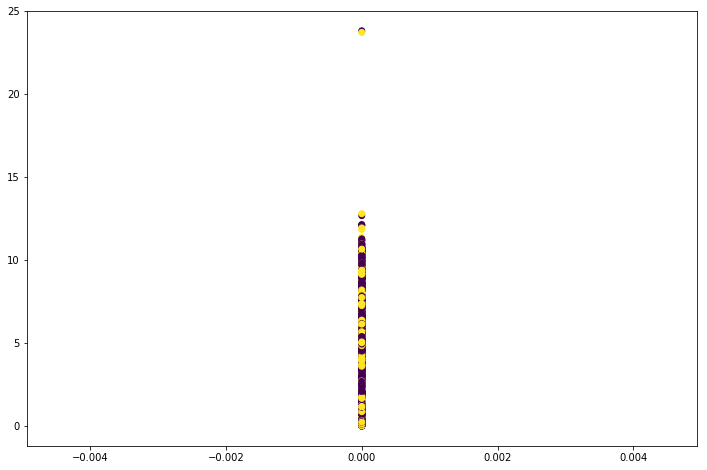

In [44]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
ax.scatter([h[0] for h in hid], [h[1] for h in hid], c=y)
plt.show()

### Run VAE encoder

In [47]:
vae = AutoEncoder(X_dim=data.shape[2], N=8, z_dim=2, 
                     train_batch_size=32, epochs=2500, 
                     dropout=0.1, opt_s='Adam', seed=None,
                     aeType='VAE')
(model, losses) = vae.generate_model(data)

Epoch-0; loss: 1.938e+05
Epoch-10; loss: 8.161e+04
Epoch-20; loss: 7.95e+04
Epoch-30; loss: 7.863e+04
Epoch-40; loss: 7.792e+04
Epoch-50; loss: 7.789e+04
Epoch-60; loss: 7.767e+04
Epoch-70; loss: 7.733e+04
Epoch-80; loss: 7.689e+04
Epoch-90; loss: 7.68e+04
Epoch-100; loss: 7.68e+04
Epoch-110; loss: 7.674e+04
Epoch-120; loss: 7.661e+04
Epoch-130; loss: 7.66e+04
Epoch-140; loss: 7.658e+04
Epoch-150; loss: 7.655e+04
Epoch-160; loss: 7.658e+04
Epoch-170; loss: 7.642e+04
Epoch-180; loss: 7.649e+04
Epoch-190; loss: 7.639e+04
Epoch-200; loss: 7.633e+04
Epoch-210; loss: 7.63e+04
Epoch-220; loss: 7.613e+04
Epoch-230; loss: 7.602e+04
Epoch-240; loss: 7.586e+04
Epoch-250; loss: 7.571e+04
Epoch-260; loss: 7.566e+04
Epoch-270; loss: 7.554e+04
Epoch-280; loss: 7.542e+04
Epoch-290; loss: 7.52e+04
Epoch-300; loss: 7.512e+04
Epoch-310; loss: 7.511e+04
Epoch-320; loss: 7.495e+04
Epoch-330; loss: 7.493e+04
Epoch-340; loss: 7.5e+04
Epoch-350; loss: 7.494e+04
Epoch-360; loss: 7.483e+04
Epoch-370; loss: 7.4

In [48]:
h = vae.get_z(torch.from_numpy(df[feat_keys].values).float())[0] # mu
h = model.encode(torch.from_numpy(df[feat_keys].values).float())[1] # mu

hid = h.detach().numpy()
np.sum(hid, axis=0)

array([ -5463.479, -13731.965], dtype=float32)

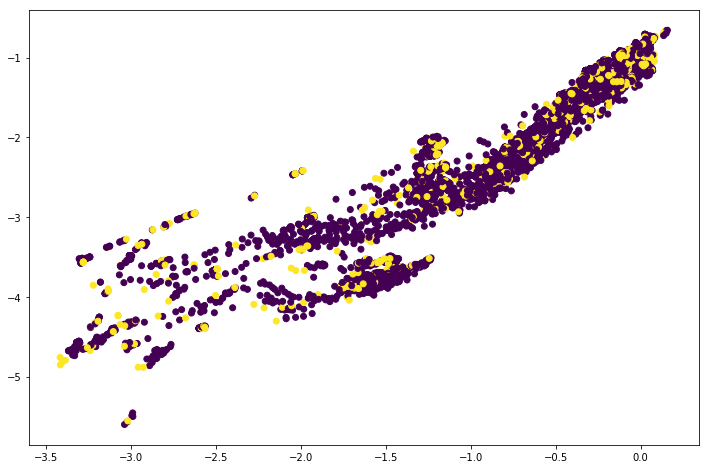

In [49]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
ax.scatter([h[0] for h in hid], [h[1] for h in hid], c=y)
plt.show()

### Run CAE encoder

In [30]:
cae = AutoEncoder(X_dim=data.shape[2], N=8, z_dim=2, 
                     train_batch_size=32, epochs=500, 
                     dropout=0.1, opt_s='Adam', seed=None,
                     aeType='CAE')
(model, losses) = cae.generate_model(data)

h = cae.get_z(torch.from_numpy(df[feat_keys].values).float())
h = model.encode(torch.from_numpy(df[feat_keys].values).float())

hid = h.detach().numpy()
np.sum(hid, axis=0)

54 8 2
54 8 2
Epoch-0; loss: 30.2
Epoch-10; loss: 5.423
Epoch-20; loss: 5.149
Epoch-30; loss: 4.947
Epoch-40; loss: 4.832
Epoch-50; loss: 4.761
Epoch-60; loss: 4.725
Epoch-70; loss: 4.716
Epoch-80; loss: 4.708
Epoch-90; loss: 4.701
Epoch-100; loss: 4.69
Epoch-110; loss: 4.679
Epoch-120; loss: 4.675
Epoch-130; loss: 4.674
Epoch-140; loss: 4.672
Epoch-150; loss: 4.761
Epoch-160; loss: 4.893
Epoch-170; loss: 4.753
Epoch-180; loss: 4.547
Epoch-190; loss: 4.476
Epoch-200; loss: 4.472
Epoch-210; loss: 4.456
Epoch-220; loss: 4.452
Epoch-230; loss: 4.436
Epoch-240; loss: 4.438
Epoch-250; loss: 4.404
Epoch-260; loss: 4.416
Epoch-270; loss: 4.449
Epoch-280; loss: 4.424
Epoch-290; loss: 4.413
Epoch-300; loss: 4.419
Epoch-310; loss: 4.405
Epoch-320; loss: 4.391
Epoch-330; loss: 4.396
Epoch-340; loss: 4.405
Epoch-350; loss: 4.404
Epoch-360; loss: 4.332
Epoch-370; loss: 4.281
Epoch-380; loss: 4.285
Epoch-390; loss: 4.27
Epoch-400; loss: 4.308
Epoch-410; loss: 4.298
Epoch-420; loss: 4.318
Epoch-430; 

array([4029.138,    0.   ], dtype=float32)

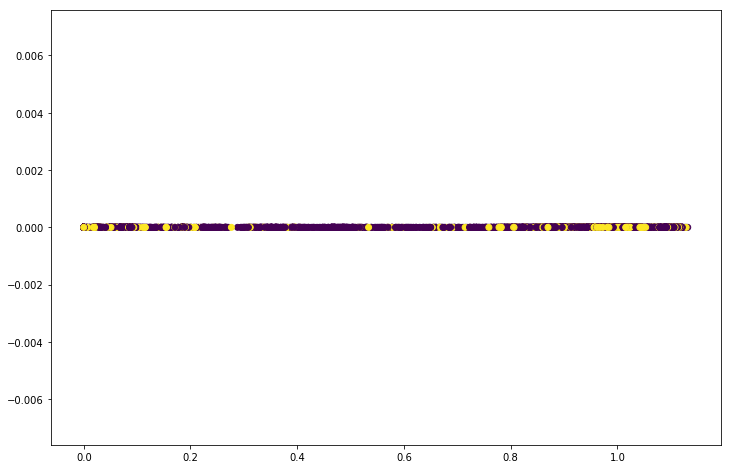

In [31]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
ax.scatter([h[0] for h in hid], [h[1] for h in hid], c=y)
plt.show()

### Run AAE encoder

In [50]:
additionalParams = {"real_gauss_A": 4.0}
aae = AutoEncoder(X_dim=data.shape[2], N=8, z_dim=2, 
                     train_batch_size=32, epochs=2500, 
                     dropout=0.1, opt_s='Adam', seed=None,
                     aeType='AAE', additionalParams=additionalParams)
(q, p, d, losses) = aae.generate_model(data)

/home/sdeev/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/sdeev/anaconda3/lib/python3.6/site-packages/torch/tensor.py:287: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


Epoch-0; D_loss_gauss: 1.24; G_loss: 0.7667; recon_loss: 0.04883
Epoch-10; D_loss_gauss: 1.301; G_loss: 1.331; recon_loss: 0.03208
Epoch-20; D_loss_gauss: 0.9818; G_loss: 1.14; recon_loss: 0.02731
Epoch-30; D_loss_gauss: 1.253; G_loss: 0.8181; recon_loss: 0.02593
Epoch-40; D_loss_gauss: 1.412; G_loss: 0.7159; recon_loss: 0.02198
Epoch-50; D_loss_gauss: 1.406; G_loss: 0.6813; recon_loss: 0.02038
Epoch-60; D_loss_gauss: 1.432; G_loss: 0.6494; recon_loss: 0.019
Epoch-70; D_loss_gauss: 1.407; G_loss: 0.6484; recon_loss: 0.01777
Epoch-80; D_loss_gauss: 1.425; G_loss: 0.6707; recon_loss: 0.01821
Epoch-90; D_loss_gauss: 1.396; G_loss: 0.6862; recon_loss: 0.01754
Epoch-100; D_loss_gauss: 1.39; G_loss: 0.6842; recon_loss: 0.01773
Epoch-110; D_loss_gauss: 1.388; G_loss: 0.6952; recon_loss: 0.01648
Epoch-120; D_loss_gauss: 1.388; G_loss: 0.6816; recon_loss: 0.01662
Epoch-130; D_loss_gauss: 1.387; G_loss: 0.6892; recon_loss: 0.01573
Epoch-140; D_loss_gauss: 1.386; G_loss: 0.6963; recon_loss: 0.017

Epoch-1220; D_loss_gauss: 1.372; G_loss: 0.694; recon_loss: 0.02094
Epoch-1230; D_loss_gauss: 1.391; G_loss: 0.6976; recon_loss: 0.01856
Epoch-1240; D_loss_gauss: 1.386; G_loss: 0.6989; recon_loss: 0.01677
Epoch-1250; D_loss_gauss: 1.392; G_loss: 0.694; recon_loss: 0.01862
Epoch-1260; D_loss_gauss: 1.39; G_loss: 0.6968; recon_loss: 0.02018
Epoch-1270; D_loss_gauss: 1.384; G_loss: 0.6968; recon_loss: 0.0187
Epoch-1280; D_loss_gauss: 1.387; G_loss: 0.6962; recon_loss: 0.01894
Epoch-1290; D_loss_gauss: 1.376; G_loss: 0.6954; recon_loss: 0.01689
Epoch-1300; D_loss_gauss: 1.389; G_loss: 0.6929; recon_loss: 0.0185
Epoch-1310; D_loss_gauss: 1.389; G_loss: 0.6962; recon_loss: 0.01815
Epoch-1320; D_loss_gauss: 1.386; G_loss: 0.6933; recon_loss: 0.02115
Epoch-1330; D_loss_gauss: 1.38; G_loss: 0.6977; recon_loss: 0.01754
Epoch-1340; D_loss_gauss: 1.388; G_loss: 0.6977; recon_loss: 0.01817
Epoch-1350; D_loss_gauss: 1.379; G_loss: 0.6961; recon_loss: 0.01841
Epoch-1360; D_loss_gauss: 1.389; G_loss:

Epoch-2410; D_loss_gauss: 1.386; G_loss: 0.6932; recon_loss: 0.01524
Epoch-2420; D_loss_gauss: 1.386; G_loss: 0.6931; recon_loss: 0.01473
Epoch-2430; D_loss_gauss: 1.386; G_loss: 0.6932; recon_loss: 0.01621
Epoch-2440; D_loss_gauss: 1.386; G_loss: 0.6931; recon_loss: 0.01653
Epoch-2450; D_loss_gauss: 1.386; G_loss: 0.6931; recon_loss: 0.01513
Epoch-2460; D_loss_gauss: 1.386; G_loss: 0.6932; recon_loss: 0.01597
Epoch-2470; D_loss_gauss: 1.386; G_loss: 0.6932; recon_loss: 0.01592
Epoch-2480; D_loss_gauss: 1.386; G_loss: 0.6932; recon_loss: 0.01571
Epoch-2490; D_loss_gauss: 1.386; G_loss: 0.6931; recon_loss: 0.01565


In [51]:
#h = aae.get_z(torch.from_numpy(df[feat_keys].values).float())
h = q.forward(torch.from_numpy(df[feat_keys].values).float())

hid = h.detach().numpy()
np.sum(hid, axis=0)

array([25854.562, 35551.516], dtype=float32)

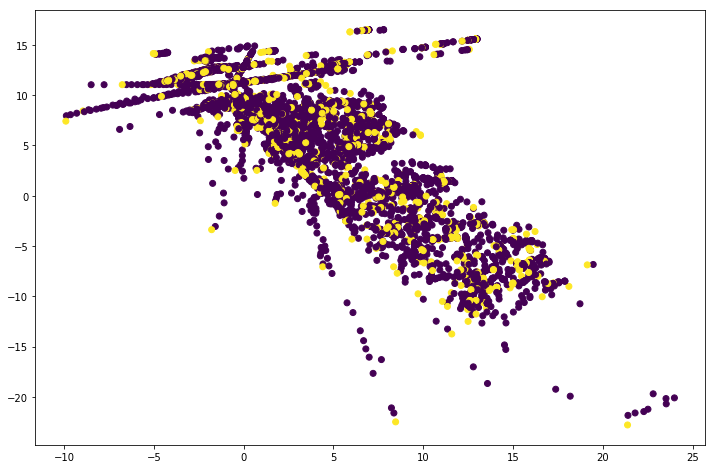

In [52]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
ax.scatter([h[0] for h in hid], [h[1] for h in hid], c=y)
plt.show()

In [46]:
feat_keys

['cohorts',
 'Spend',
 'Reach',
 'Impressions',
 'Clicks',
 'Installs',
 'Payers',
 'Purchases',
 'Revenue',
 'SpendSum',
 'ReachSum',
 'ImpressionsSum',
 'ClicksSum',
 'InstallsSum',
 'PayersSum',
 'PurchasesSum',
 'RevenueSum',
 'SpendWin3',
 'ReachWin3',
 'ImpressionsWin3',
 'ClicksWin3',
 'InstallsWin3',
 'PayersWin3',
 'PurchasesWin3',
 'RevenueWin3',
 'SpendWin7',
 'ReachWin7',
 'ImpressionsWin7',
 'ClicksWin7',
 'InstallsWin7',
 'PayersWin7',
 'PurchasesWin7',
 'RevenueWin7',
 'Day',
 'Month',
 'Weekday',
 'Week',
 'Opt_OFFSITE_CONVERSIONS_1',
 'Opt_OFFSITE_CONVERSIONS_7',
 'Opt_VALUE_1',
 'Opt_VALUE_7',
 'Location_16group',
 'Location_23group',
 'Location_2group',
 'Location_5group',
 'Location_6group',
 'Location_8group',
 'Location_DE',
 'Location_JP',
 'Location_KR',
 'Location_RU',
 'Location_TW',
 'Location_US',
 'Location_WW']

In [56]:
a = None
a = vae
print(a is None)

False
